In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [108]:
class BinomialTree():

    def __init__(self,S0,K,r,sigma,T,N):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.N = N #number of steps
        self.delta_t = T/N
        self.u = np.exp(sigma*np.sqrt(self.delta_t)) #CRR_u_approx
        self.d = 1/self.u #CRR_d_approx
        self.q = (np.exp(self.r*self.delta_t) - self.d)/(self.u-self.d)


    def european_price_option(self, option_type, all_tree=False):
       
        stock_tree = np.zeros((self.N + 1, self.N + 1))
        
        if option_type in ("call", "put"):
            for i in range(self.N + 1):
                for j in range(i + 1):
                    stock_tree[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)
        elif option_type == "put lookback":
            for j in range(self.N + 1):
                stock_tree[j, j:] = 1 * (self.u ** (j))            
        
        # Step 2: Initialize option price tree at maturity
        option_tree = np.zeros((self.N + 1, self.N + 1))
        if option_type == 'call':
            option_tree[:, self.N] = np.maximum(0, stock_tree[:, self.N] - self.K)
        elif option_type == 'put':
            option_tree[:, self.N] = np.maximum(0, self.K - stock_tree[:, self.N])
        elif option_type == 'put lookback':
            option_tree[:, self.N] = stock_tree[:, self.N] - 1

        # Step 3: Backward induction for option price at each node
        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                if option_type in ("call", "put"):
                    option_tree[j, i] = np.exp(-self.r * self.delta_t) * (self.q * option_tree[j, i + 1] + (1 - self.q) * option_tree[j + 1, i + 1])
                elif option_type == "put lookback":
                    option_tree[j, i] = np.exp(-self.r * self.delta_t) * (self.q * self.u * option_tree[j, i + 1] + (1 - self.q) * self.d * option_tree[j + 1, i + 1])

        if all_tree:
            return option_tree
        else:
            if option_type == "put lookback":
                return option_tree[0, 0]*self.S0
            else:
                return option_tree[0, 0]
    
    def american_price_option(self, option_type):

        stock_tree = np.zeros((self.N + 1, self.N + 1))
        for i in range(self.N + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)
        
        # Step 2: Initialize option price tree at maturity
        option_tree = np.zeros((self.N + 1, self.N + 1))
        if option_type == 'call':
            option_tree[:, self.N] = np.maximum(0, stock_tree[:, self.N] - self.K)
        elif option_type == 'put':
            option_tree[:, self.N] = np.maximum(0, self.K - stock_tree[:, self.N])

        # Step 3: Backward induction for american option price
        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                # Calculate the value of holding the option
                hold_value = np.exp(-self.r * self.delta_t) * (self.q * option_tree[j, i + 1] + (1 - self.q) * option_tree[j + 1, i + 1])

                # Calculate the intrinsic value of exercising the option immediately
                if option_type == 'call':
                    exercise_value = max(0, stock_tree[j, i] - self.K)
                elif option_type == 'put':
                    exercise_value = max(0, self.K - stock_tree[j, i])

                # Take the maximum of holding and exercising
                option_tree[j, i] = max(hold_value, exercise_value)

        return option_tree[0, 0]


def binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type):
    ranging = range(5,Nmax +1,1)
    price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        price_N[i] = binomTree.european_price_option(option_type)
    return price_N

def american_binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type):
    ranging = range(5,Nmax +1,1)
    call_price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        call_price_N[i] = binomTree.american_price_option(option_type)
    return call_price_N


In [109]:
bt = BinomialTree(S0=100,K=None,r=0.05,sigma=0.02,T=0.5,N=10)
treeVals = bt.european_price_option("put lookback", all_tree=True)

In [111]:
treeVals[:, -1]

array([0.        , 0.00448215, 0.00898439, 0.01350681, 0.0180495 ,
       0.02261255, 0.02719606, 0.03180011, 0.03642479, 0.0410702 ,
       0.04573643])

In [135]:
treeVals[0,0]*100

0.9892098819140849

In [112]:
treeVals[:, -2]

array([0.00098483, 0.0054714 , 0.00997807, 0.01450495, 0.01905211,
       0.02361966, 0.02820767, 0.03281626, 0.0374455 , 0.04209548,
       0.        ])

In [123]:
treeVals[:, 10]

array([0.        , 0.00448215, 0.00898439, 0.01350681, 0.0180495 ,
       0.02261255, 0.02719606, 0.03180011, 0.03642479, 0.0410702 ,
       0.04573643])

In [120]:
bt.d * (1 - bt.q) * (bt.u**2 - 1) * np.exp(-bt.r * bt.delta_t)

0.0019740818941206503

In [130]:
(bt.u - 1)

0.0044821508788011055

In [125]:
j = 0
i = 9
np.exp(-bt.r * bt.delta_t) * (bt.q * bt.u * treeVals[j, i + 1] + (1 - bt.q) * bt.d * treeVals[j + 1, i + 1])

0.0009848338600845976

In [127]:
(1 - bt.q) * bt.d * treeVals[j + 1, i + 1]

0.0009872990249068972

In [128]:
treeVals[j + 1, i + 1]

0.0044821508788011055

In [101]:
np.exp(bt.sigma * np.sqrt(bt.delta_t))

1.004482150878801

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


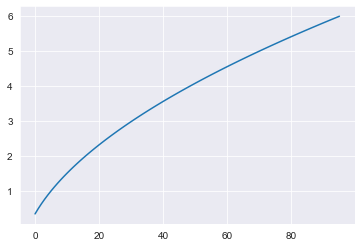

In [106]:
plt.plot(binomial_pricing_N(S0=100,K=None,r=0.05,sigma=0.02,T=0.5,Nmax=100, option_type='put lookback'))

In [78]:
bt.u**4

1.0180495021576463

In [59]:
stock_tree = np.zeros((bt.N + 1, bt.N + 1))
for j in range(bt.N + 1):
    stock_tree[j, j:] = 1 * (bt.u ** (j))

In [60]:
stock_tree

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.        , 1.06528839, 1.06528839, 1.06528839, 1.06528839,
        1.06528839, 1.06528839, 1.06528839, 1.06528839, 1.06528839,
        1.06528839],
       [0.        , 0.        , 1.13483936, 1.13483936, 1.13483936,
        1.13483936, 1.13483936, 1.13483936, 1.13483936, 1.13483936,
        1.13483936],
       [0.        , 0.        , 0.        , 1.2089312 , 1.2089312 ,
        1.2089312 , 1.2089312 , 1.2089312 , 1.2089312 , 1.2089312 ,
        1.2089312 ],
       [0.        , 0.        , 0.        , 0.        , 1.28786037,
        1.28786037, 1.28786037, 1.28786037, 1.28786037, 1.28786037,
        1.28786037],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.3719427 , 1.3719427 , 1.3719427 , 1.3719427 , 1.3719427 ,
        1.3719427 ],
       [0.        , 0.        , 0.        , 0.        , 0.

[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
[[100.         106.52883921   0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.          93.87129414   0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.  

In [41]:
stock_tree

array([[100.        , 106.52883921, 113.48393583, 120.89311953,
        128.78603692, 137.1942702 , 146.1514635 , 155.69345756,
        165.85843306, 176.68706347, 188.22267775],
       [  0.        ,  93.87129414, 100.        , 106.52883921,
        113.48393583, 120.89311953, 128.78603692, 137.1942702 ,
        146.1514635 , 155.69345756, 165.85843306],
       [  0.        ,   0.        ,  88.11819864,  93.87129414,
        100.        , 106.52883921, 113.48393583, 120.89311953,
        128.78603692, 137.1942702 , 146.1514635 ],
       [  0.        ,   0.        ,   0.        ,  82.71769344,
         88.11819864,  93.87129414, 100.        , 106.52883921,
        113.48393583, 120.89311953, 128.78603692],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         77.64816931,  82.71769344,  88.11819864,  93.87129414,
        100.        , 106.52883921, 113.48393583],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  72.88934141,  77.6

In [39]:
treeVals[10]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       56.87143909])

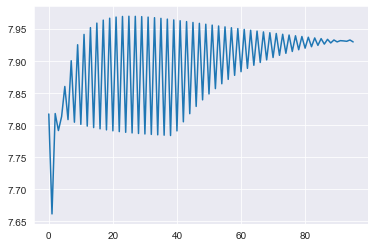

In [10]:
plt.plot(binomial_pricing_N(100, 110, 0.05, 0.2, 10, 100, "put"))